### RNN LSTM German Newset
This notebook follows the steps of the RNN notebook presented in class.
The result seem to be much better than the CNN results but still not very good, so I will not go into further details.

Also I oberserved a lot of problems with the GPU which run in multiple OOM error. Had to restart the kernel and descrease batch size.

Even after 10 epochs the average f1-score is only about 0.75.
Maybe using a more complicated RNN architecture would help but I suspect the number of examples in the dataset to be to small for such a deep learning technique.


In [2]:
!pip install 'fhnw-nlp-utils>=0.1.3'
!pip install pyarrow fastparquet fasttext 
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.colab import runs_on_colab

import numpy as np
import pandas as pd

import tensorflow as tf

print("Tensorflow version:", tf.__version__)

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version: 2.5.1
GPU is available


In [3]:
# Use prepared data
file = "data/german_news_articles_original_train_and_test_tokenized.parq"
data_all = load_dataframe(file)

In [4]:
data_all.sample(3)

,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
1284,"""Die Presse"": Grund sei die Kooperation mit de...",Wirtschaft,train,Die Presse Grund sei die Kooperation mit dem ...,"[presse, grund, sei, kooperation, russischen, ...","[presse, grund, kooperation, russisch, energie...","[press, grund, sei, kooperation, russisch, ene...","[presse, grund, sei, kooperation, russischen, ..."
4343,Fünf Töpfe mit insgesamt 35 Millionen Euro sol...,Etat,train,Fünf Töpfe mit insgesamt Millionen Euro soll d...,"[fünf, töpfe, insgesamt, millionen, euro, refo...","[fünf, topf, insgesamt, million, euro, reform,...","[funf, topf, insgesamt, million, euro, reform,...","[fünf, töpfe, insgesamt, millionen, euro, refo..."
5817,"Viele ""Likes"" und Follower, aber nur ein Eintr...",Panorama,train,Viele Likes und Follower aber nur ein Eintrag ...,"[viele, likes, follower, eintrag, zwei, opfer,...","[likes, follower, eintrag, zwei, opfer, weiter...","[viel, lik, follow, eintrag, zwei, opf, weiter...","[viele, likes, follower, eintrag, zwei, opfer,..."


In [5]:
from fhnw.nlp.utils.params import get_train_test_split, extract_vocabulary_and_set,create_label_binarizer_and_set, extract_text_vectorization_and_set

In [6]:
# used standard params from class

params = {
    "verbose": True,
    "shuffle": True,
    "batch_size": 32,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "embedding_type": "fasttext",
    #"embedding_type": "bytepair",
    "embedding_dim": 300,
    "embedding_mask_zero": True,
    "embedding_trainable": False,
    #"embedding_input_sequence_length": output_sequence_length if 'output_sequence_length' in locals() or 'output_sequence_length' in globals() else None,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

In [7]:
create_label_binarizer_and_set(params, data_all)
extract_vocabulary_and_set(params, data_all)

Inferred classification type: multi-class
Median sequence length: 171
Percentil (0.98) cutoff sequence length: 582
Max sequence length: 2563
Used embedding sequence length: 582


In [8]:
extract_text_vectorization_and_set(params)

Vocabulary length: 186181


In [9]:
%%time
from fhnw.nlp.utils.params import extract_embedding_layer_and_set, dataframe_to_dataset

extract_embedding_layer_and_set(params)

Embedding type: fasttext
Number of null word embeddings: 4
Words not found in total: 4
Words without embedding (4/4): ['qz', 'öw', 'yq', '']
CPU times: user 6.05 s, sys: 4.75 s, total: 10.8 s
Wall time: 13.5 s


In [10]:
data_train_orig = data_all.loc[(data_all["split"] == "train")]
data_test_orig = data_all.loc[(data_all["split"] == "test")]


data_train, data_test = get_train_test_split(params, data_train_orig)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)

7396 train examples
1849 test examples


In [11]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

{'text_clean': <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Ivan Origone ist damit der schnellste Mann auf Skiern Der Italiener Ivan Origone hat mit fast Stundenkilometern einen neuen Geschwindigkeitsrekord im Skifahren aufgestellt und damit die Weltbestleistung seines Bruders \xc3\xbcbertroffen Der J\xc3\xa4hrige fuhr am Samstag bei den Speed Masters in Vars in den franz\xc3\xb6sischen Alpen Stundenkilometer schnell Sein J\xc3\xa4hriger Bruder Simone hatte in dem Rennen seinen Weltrekord vom vergangenen Jahr damals fuhr er Stundenkilometer zwar mit Stundenkilometern leicht \xc3\xbcberboten Doch sein Bruder war noch deutlich schneller Einen neuen Weltrekord bei den Damen stellte die Italienerin Valentina Greggio auf Sie fuhr Stundenkilometer schnell Der \xc3\xb6sterreichische Herrenrekord steht seit Samstag bei km Aufgestellt hat ihn der j\xc3\xa4hrige Bad Mitterndorfer Klaus Schrottshammer Den alten Rekord hielt der Tiroler Harry Egger seit mit km ',
       b'Das Molek\xc3\x

In [12]:
from fhnw.nlp.utils.params import build_model_rnn, compile_model, train_model
# Use CNN model
model = build_model_rnn(params)
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         55854300  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_dropout (Dropout)      (None, 16)                0         
_________________________________________________________________
prediction (Dense)           (None, 9)                 153       
Total params: 55,940,741
Trainable params: 86,441
Non-trainable params: 55,854,300
______________________________________________

In [13]:
compile_model(params, model)
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [14]:
# Training is fast enough so increase number of epochs
params["training_epochs"] = 10
history = train_model(params, model, dataset_train, dataset_test)

Epoch 1/10
232/232 [==============================] - 215s 895ms/step - loss: 1.8444 - accuracy: 0.3246 - val_loss: 1.6819 - val_accuracy: 0.4094
Epoch 2/10
232/232 [==============================] - 211s 913ms/step - loss: 1.7536 - accuracy: 0.3469 - val_loss: 1.4067 - val_accuracy: 0.4927
Epoch 3/10
232/232 [==============================] - 236s 1s/step - loss: 1.5085 - accuracy: 0.4305 - val_loss: 1.2314 - val_accuracy: 0.5176
Epoch 4/10
232/232 [==============================] - 215s 925ms/step - loss: 1.4263 - accuracy: 0.4663 - val_loss: 1.1770 - val_accuracy: 0.5679
Epoch 5/10
232/232 [==============================] - 219s 946ms/step - loss: 1.2840 - accuracy: 0.5193 - val_loss: 1.0457 - val_accuracy: 0.6220
Epoch 6/10
232/232 [==============================] - 217s 937ms/step - loss: 1.1510 - accuracy: 0.5649 - val_loss: 0.9632 - val_accuracy: 0.6382
Epoch 7/10
232/232 [==============================] - 215s 927ms/step - loss: 1.0744 - accuracy: 0.5945 - val_loss: 0.8721 - va

INFO:tensorflow:Assets written to: models/rnn/20211122-032323/model_0.72904/assets


INFO:tensorflow:Assets written to: models/rnn/20211122-032323/model_0.72904/assets


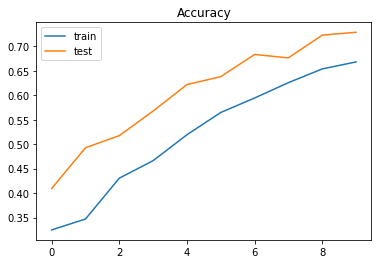

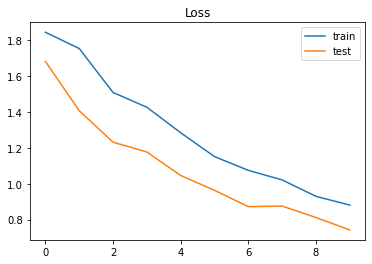

In [15]:
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.params import save_model

save_model(params, model, history)
plot_history(history)

In [17]:
import os
from tensorflow import keras
model_save_path = 'models/rnn/20211122-032323/model_0.72904'
model = keras.models.load_model(model_save_path)

In [18]:
# Unfreeze all layers (i.e. make embeddings trainable)
model.trainable = True
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         55854300  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_dropout (Dropout)      (None, 16)                0         
_________________________________________________________________
prediction (Dense)           (None, 9)                 153       
Total params: 55,940,741
Trainable params: 55,940,741
Non-trainable params: 0
___________________________________________________

In [19]:
from fhnw.nlp.utils.params import re_compile_model
re_compile_model(params, model)

In [20]:
params["training_epochs"] = 3
history = train_model(params, model, dataset_train, dataset_test)

Epoch 1/3
232/232 [==============================] - 334s 1s/step - loss: 0.7830 - accuracy: 0.7112 - val_loss: 0.7362 - val_accuracy: 0.7355
Epoch 2/3
232/232 [==============================] - 327s 1s/step - loss: 0.7592 - accuracy: 0.7165 - val_loss: 0.7321 - val_accuracy: 0.7388
Epoch 3/3
232/232 [==============================] - 321s 1s/step - loss: 0.7496 - accuracy: 0.7185 - val_loss: 0.7284 - val_accuracy: 0.7409


INFO:tensorflow:Assets written to: models/rnn/20211122-035252/model_0.74094/assets


INFO:tensorflow:Assets written to: models/rnn/20211122-035252/model_0.74094/assets


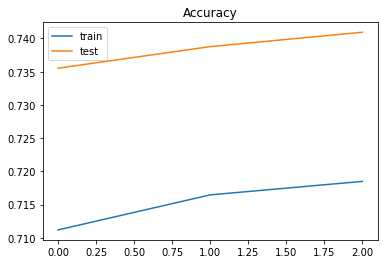

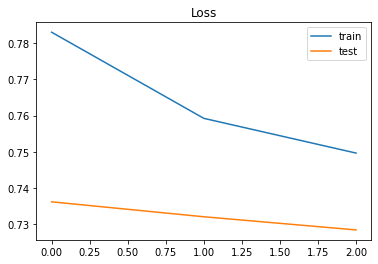

In [22]:
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.params import save_model

save_model(params, model, history)
plot_history(history)

In [14]:
import os
from tensorflow import keras
model_save_path = 'models/rnn/20211122-035252/model_0.74094'
model = keras.models.load_model(model_save_path)

Set Population: 1028
Accuracy: 0.7471


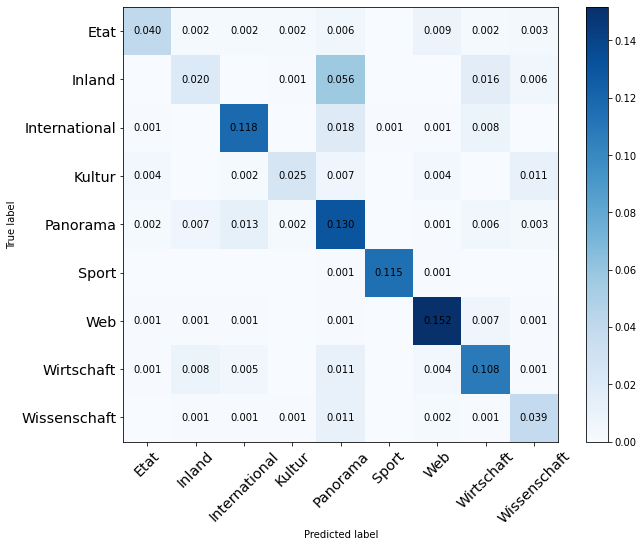

               precision    recall  f1-score   support

         Etat       0.82      0.61      0.70        67
       Inland       0.53      0.21      0.30       102
International       0.83      0.80      0.82       151
       Kultur       0.81      0.48      0.60        54
     Panorama       0.54      0.80      0.64       168
        Sport       0.99      0.98      0.99       120
          Web       0.88      0.93      0.90       168
   Wirtschaft       0.74      0.79      0.76       141
 Wissenschaft       0.62      0.70      0.66        57

     accuracy                           0.75      1028
    macro avg       0.75      0.70      0.71      1028
 weighted avg       0.75      0.75      0.74      1028



In [15]:
from fhnw.nlp.utils.ploting import report_classification_results
params['batch_size'] = 16
report_classification_results(params, data_test_orig, model)